### Import libraries

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time

### url 

In [2]:
driver = webdriver.Chrome()
driver.get('https://internshala.com/internships/data-analytics-internship')
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

## Intializing list

In [3]:
jobs = []

### Extracting Data

In [4]:
for card in soup.find_all('div', class_='individual_internship'):
    # Title
    title_tag = card.select_one('h3.job-internship-name a.job-title-href')
    title = title_tag.text.strip() if title_tag else 'Not found'

    # Company
    company_tag = card.select_one('p.company-name')
    company = company_tag.text.strip() if company_tag else 'Not found'

    # Location
    location_tag = card.select_one('div.row-1-item.locations a')
    location = location_tag.text.strip() if location_tag else 'Not found'

    # Stipend
    stipend_tag = card.select_one('span.stipend')
    stipend = stipend_tag.text.strip() if stipend_tag else 'Not disclosed'

    # Skills
    skill_tags = card.select('div.job_skill')
    skills = ', '.join([skill.text.strip() for skill in skill_tags]) if skill_tags else 'Not listed'

    jobs.append({
        'Title': title,
        'Company': company,
        'Location': location,
        'Stipend': stipend,
        'Skills': skills
    })

### Making a dataframe form the data extracted

In [5]:
df = pd.DataFrame(jobs)
df.to_csv('internshala_data_analytics_jobs.csv', index=False)
print("Scraped", len(jobs), "jobs from Internshala.")

Scraped 42 jobs from Internshala.


### Reading dataframe

In [6]:
df = pd.read_csv("internshala_data_analytics_jobs.csv")

### Printing top rows

In [7]:
df.head()

,Title,Company,Location,Stipend,Skills
0,Not found,Not found,Not found,Not disclosed,Not listed
1,Digital Merchandiser Intern,Decathlon,Bangalore,Competitive stipend,"Adobe Photoshop, Adobe Illustrator, E-commerce..."
2,Data Analytics,Aakar Innovations Private Limited,Navi Mumbai,"₹ 25,000 - 35,000 /month","Python, SQL, Data Analytics, Data Science, RES..."
3,Business Analytics,Fabapps Lab Pvt Ltd,Silvassa,"₹ 15,000 - 25,000 /month","MS-Office, Project Management, Software Testin..."
4,Video Data Annotator,Indika AI Private Limited,Work from home,"₹ 8,000 - 15,000 /month","Attention to Detail, Time Management, Data Ana..."


### Filtering Dataset with non-tiles rows

In [8]:
df = df[~((df['Title'] == 'Not found') & (df['Company'] == 'Not found'))]

### Filtering dataset for data analyst jobs(in case)

In [9]:
title_keywords = ['data analyst', 'data analytics', 'business analyst', 'data science']
skill_keywords = ['python', 'sql', 'data analytics', 'data science']

df_filtered = df[
    df['Title'].str.lower().str.contains('|'.join(title_keywords)) |
    df['Skills'].str.lower().str.contains('|'.join(skill_keywords))
]

In [10]:
df_filtered.head()

,Title,Company,Location,Stipend,Skills
1,Digital Merchandiser Intern,Decathlon,Bangalore,Competitive stipend,"Adobe Photoshop, Adobe Illustrator, E-commerce..."
2,Data Analytics,Aakar Innovations Private Limited,Navi Mumbai,"₹ 25,000 - 35,000 /month","Python, SQL, Data Analytics, Data Science, RES..."
3,Business Analytics,Fabapps Lab Pvt Ltd,Silvassa,"₹ 15,000 - 25,000 /month","MS-Office, Project Management, Software Testin..."
4,Video Data Annotator,Indika AI Private Limited,Work from home,"₹ 8,000 - 15,000 /month","Attention to Detail, Time Management, Data Ana..."
5,E-Commerce Operations,Aranqa,Mumbai,"₹ 12,000 - 16,000 /month","Digital Marketing, Data Analytics, Search Engi..."


### Size of filtered dataset

In [11]:
print("Total jobs scraped:", len(df_filtered))

Total jobs scraped: 40


### Check for NULL Values

In [12]:
df_filtered.isnull().sum()

Title       0
Company     0
Location    0
Stipend     0
Skills      0
dtype: int64

### Check for duplicate value

In [13]:
df_filtered.duplicated().sum()

0

### Top Locations

In [15]:
top_locations = df['Location'].value_counts().head(5)
print(top_locations)

Location
Work from home    23
Mumbai             4
Bangalore          3
Delhi              3
Navi Mumbai        1
Name: count, dtype: int64


### Pie Chart(for top locations)

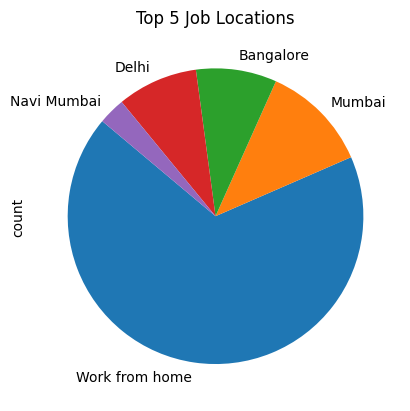

In [16]:
import matplotlib.pyplot as plt
top_locations.plot(kind='pie', startangle=140)
plt.title('Top 5 Job Locations')
plt.show()

### Most In-Demand Skills

In [17]:
from collections import Counter

all_skills = ','.join(df['Skills'].dropna()).lower().split(',')
skill_counts = Counter([skill.strip() for skill in all_skills if skill.strip()])
top_skills = skill_counts.most_common(10)
skill_df = pd.DataFrame(top_skills, columns=['Skill', 'Count'])
print(skill_df)

                               Skill  Count
0                     data analytics     40
1                             python     20
2                           ms-excel     17
3                                sql     15
4                       data science     12
5                   machine learning      9
6                           power bi      7
7                          ms-office      7
8       english proficiency (spoken)      7
9  natural language processing (nlp)      6


### Bar Plot of Top Skills

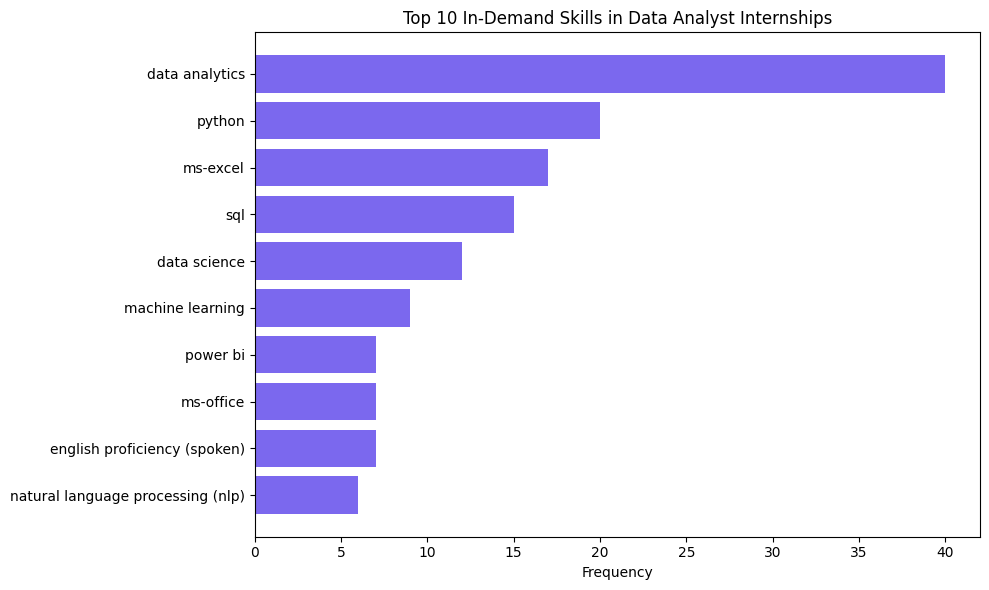

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(skill_df['Skill'], skill_df['Count'], color='mediumslateblue')
plt.xlabel('Frequency')
plt.title('Top 10 In-Demand Skills in Data Analyst Internships')
plt.gca().invert_yaxis()  # Highest skill at top
plt.tight_layout()
plt.show()

### Extract Numeric Stipend Values

In [19]:
import re

def extract_stipend(stipend_str):
    match = re.search(r'₹\s*([\d,]+)', stipend_str)
    if match:
        return int(match.group(1).replace(',', ''))
    else:
        return None  # Skip "Competitive stipend" or "Not disclosed"

df['Stipend_numeric'] = df['Stipend'].apply(extract_stipend)

### Visualize Stipend Distribution

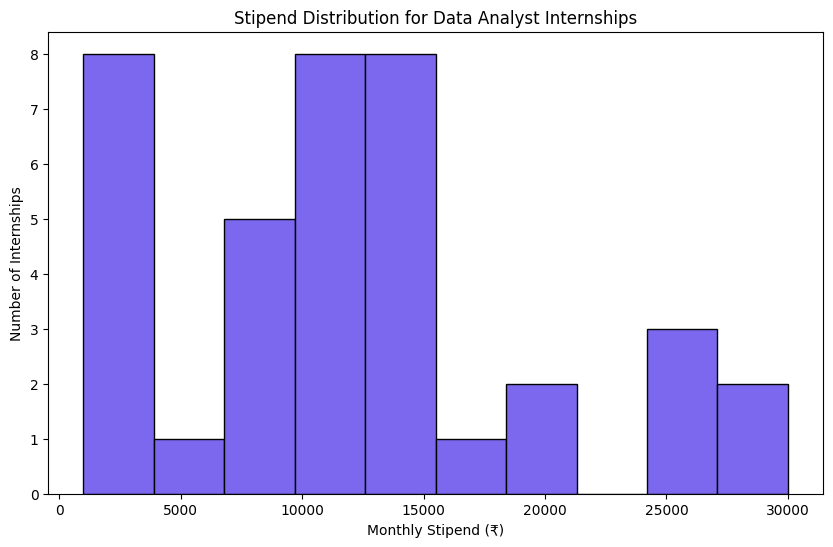

In [20]:
plt.figure(figsize=(10, 6))
df['Stipend_numeric'].dropna().plot(kind='hist',edgecolor='black', bins=10, color='mediumslateblue')
plt.title('Stipend Distribution for Data Analyst Internships')
plt.xlabel('Monthly Stipend (₹)')
plt.ylabel('Number of Internships')
plt.show()

### Highest Paying Internship

In [21]:
top_job = df.loc[df['Stipend_numeric'].idxmax()]
print("Highest paying internship:")
print(top_job[['Title', 'Company', 'Location', 'Stipend']])

Highest paying internship:
Title         Data Analytics
Company     APEX ENGINEERING
Location      Work from home
Stipend      ₹ 30,000 /month
Name: 16, dtype: object
